In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

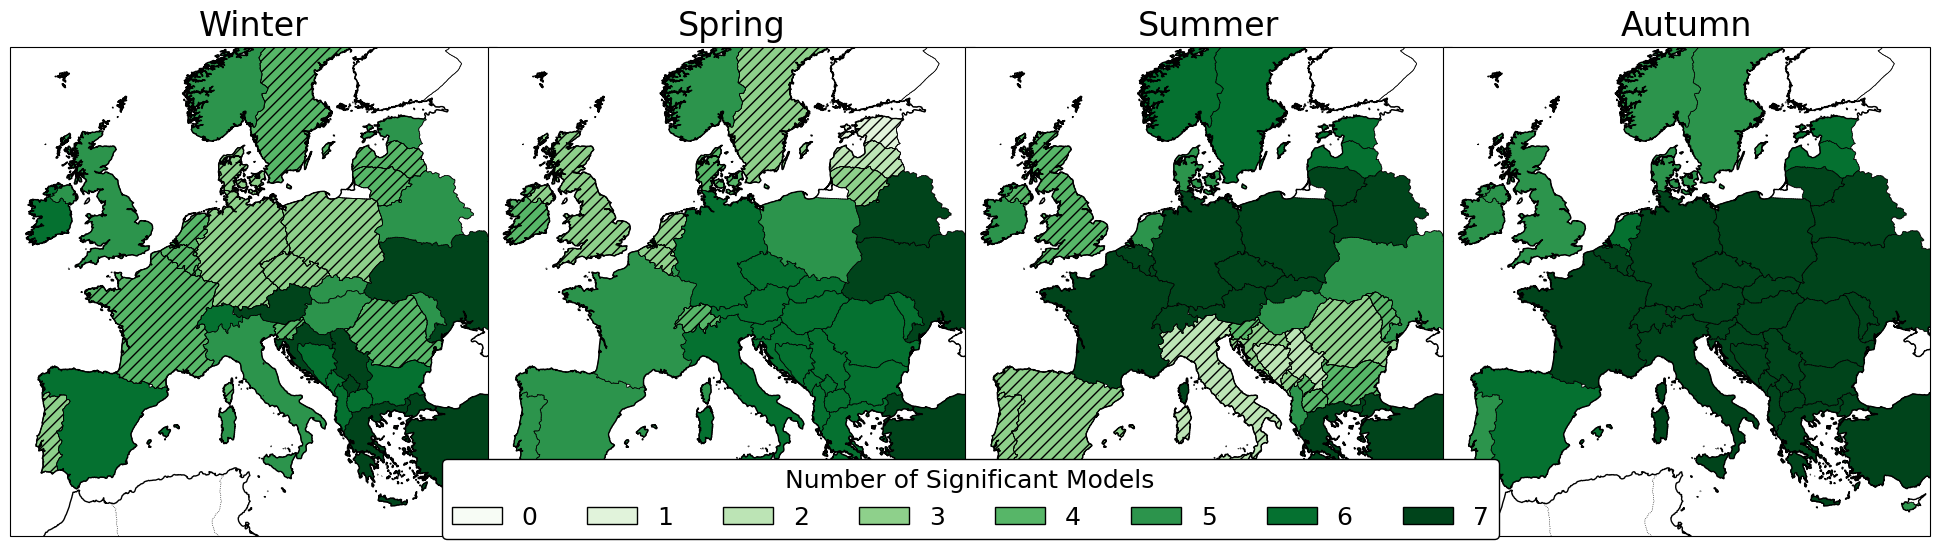

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load the seasonal summary
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Regions
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
    'UA','BY','MD','RU','XK'
]
region_codes = EU27 + extras

# 3) Country geometries
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',  'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway',  'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# 4) Prepare colormap + norm for up to maxm
maxm = int(summary['n_models_significant'].max())
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# 5) Seasons and 1×4 axes
seasons = ['Winter','Spring','Summer','Autumn']
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    1, 4,
    figsize=(20, 8),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

# 6) Plot each season
for ax, season in zip(axes, seasons):
    df_seas = summary[summary['season'] == season]
    gdf = eu.merge(
        df_seas[['ISO_A2','n_models_significant']],
        on='ISO_A2',
        how='left'
    ).copy()
    # fill missing with 0 and convert to int
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)
    # mask RU & FI
    gdf.loc[gdf['ISO_A2'].isin(['RU','FI']), 'n_models_significant'] = np.nan

    # main choropleth
    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'white'}
    )

    # hatching for low-agreement
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        hatch='///',
        linewidth=0.5,
        zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.set_title(season, fontsize=24, pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    lat0 = (33 + 65) / 2
    ax.set_aspect(1/np.cos(np.deg2rad(lat0)), adjustable='box')

## … (everything up through plotting the 1×4 maps) …

# 6) Manually fix the axes region so all 4 panels are identical
fig.subplots_adjust(
    left=0.02,   # left edge of first panel
    right=0.98,  # right edge of last panel
    top=0.90,    # top edge of panels
    bottom=0.15, # reserve bottom 15% for the legend
    wspace=-0.02  # small horizontal padding
)

# 7) Now add the shared legend in that 15%-high band at the bottom
patches = [
    mpatches.Patch(facecolor=cmap(i),
                   edgecolor='black',
                   linewidth=1,
                   label=str(i))
    for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Number of Significant Models",
    loc="lower center",
    ncol=8,
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor="black",
    bbox_to_anchor=(0.5, 0.2),  # centered at 5% above figure bottom
    framealpha=1
)

# 8) Save & show
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_agreement_power_1x4.pdf",bbox_inches="tight", dpi=300)
plt.show()


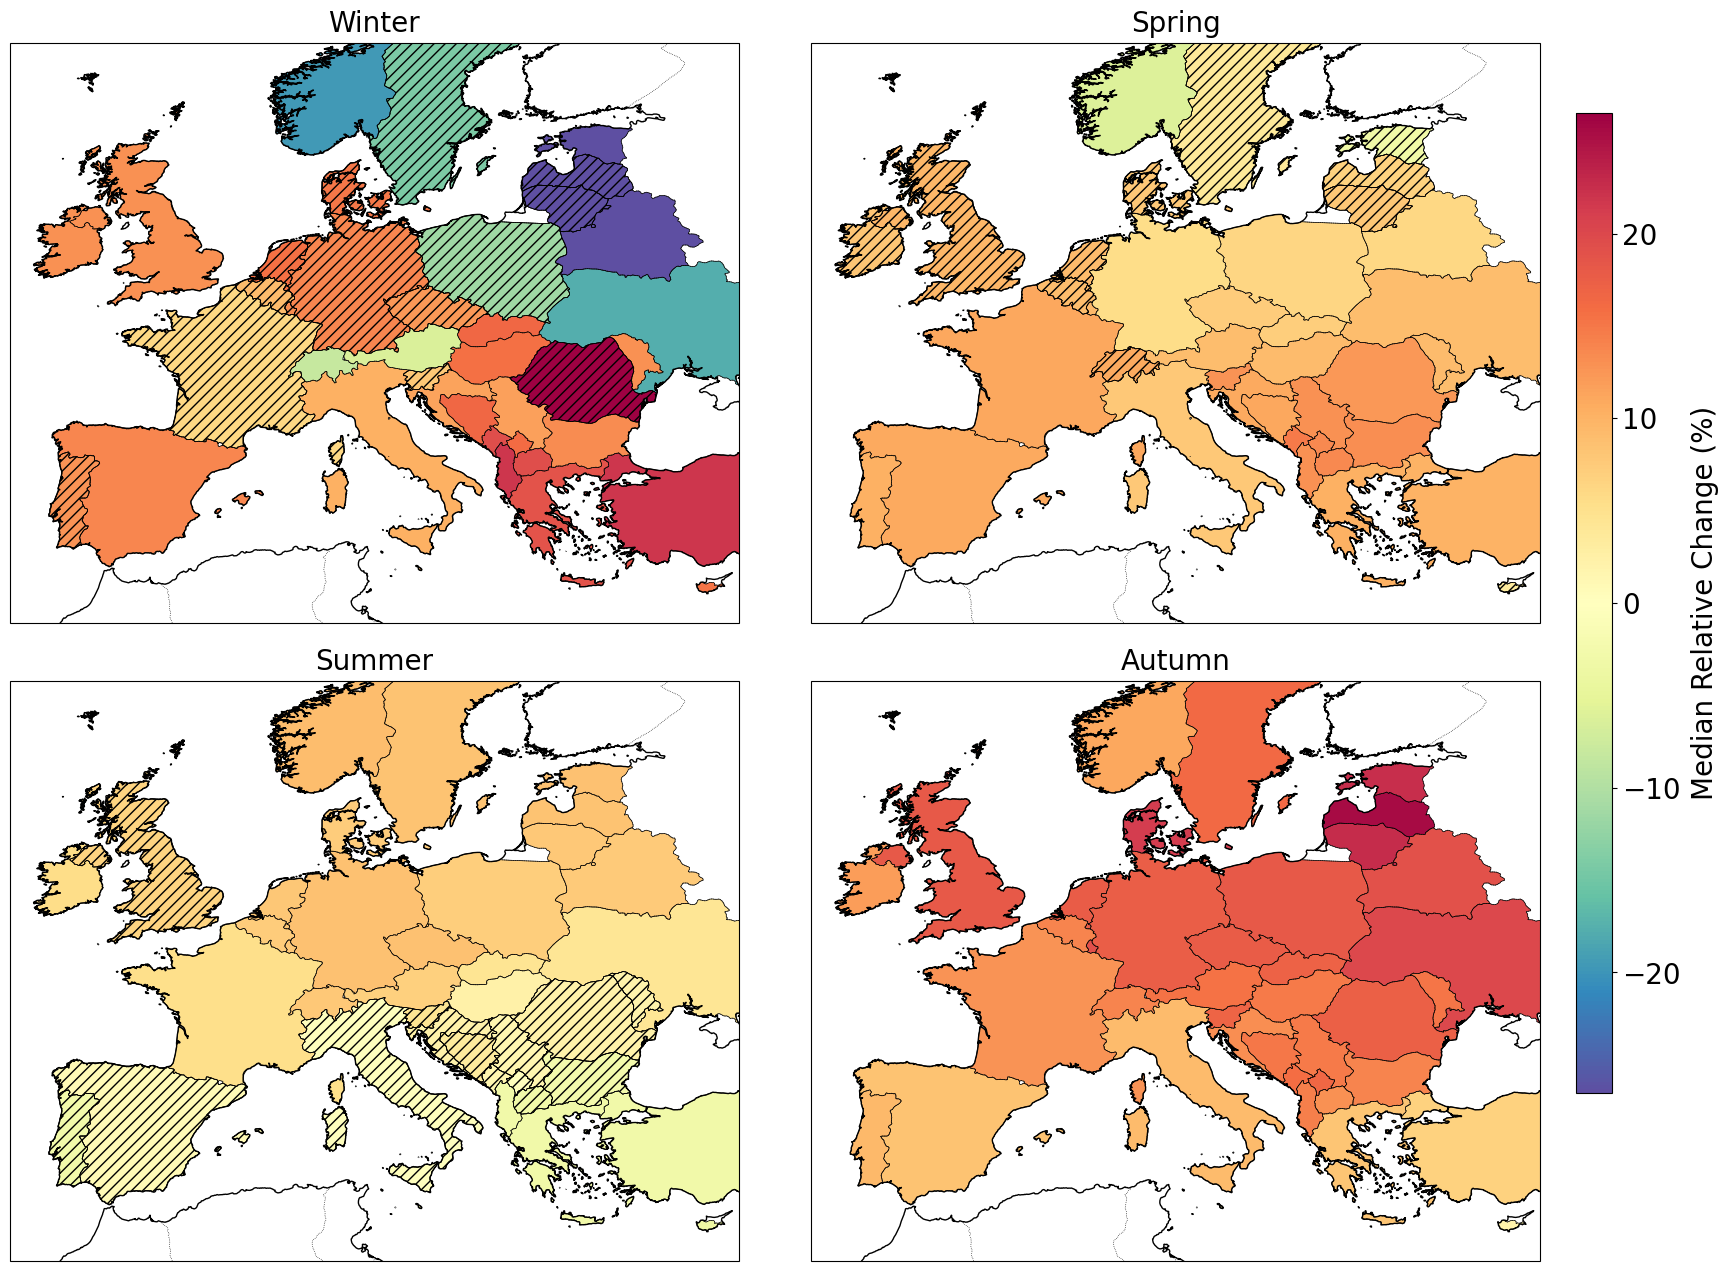

In [56]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib as mpl

# 1) Load your seasonal summary (with a 'season' column)
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Region codes & Natural Earth
EU27 = ['AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
        'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
        'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
codes = EU27 + extras

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France','ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway','ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False),'ISO_A2'] = 'XK'

eu_base = world[world.ISO_A2.isin(codes)][['ISO_A2','geometry']].copy()

# 3) Colour scale
vmin = summary['median_rel_change_sig'].quantile(0)
vmax = summary['median_rel_change_sig'].quantile(1)
norm = mpl.colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

from matplotlib.colors import LinearSegmentedColormap

# Create a lighter version of RdBu_r
original_cmap = plt.get_cmap('Spectral_r')
colors = original_cmap(np.linspace(0, 1, 256))
lighter_colors = (1 - 0.2) * colors + 0.2  # Blend with white (adjust 0.5 for more/less lightness)
lighter_cmap = LinearSegmentedColormap.from_list('Spectral_r', lighter_colors)
cmap = original_cmap

# 4) Figure + 2×2 axes (no constrained_layout)
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': proj}
)

# 5) Plot each season
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season'] == season]

    eu_sign= eu_base.merge(
        df_seas[['ISO_A2', 'n_models_significant']],
        on='ISO_A2', how='left'
    )
    eu_sign['n_models_significant'] = eu_sign['n_models_significant'].fillna(0).astype(int)
    eu = eu_base.merge(df_seas[['ISO_A2', 'median_rel_change_sig']],
                       on='ISO_A2', how='left')
    eu['median_rel_change_sig'] = eu['median_rel_change_sig'].fillna(0)

    # Plot the main map
    eu.plot(
        column='median_rel_change_sig',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, legend=False,
        missing_kwds={'color': 'lightgrey'}
    )

    # Apply hatching for countries with fewer than 5 significant models
    low = eu_sign[eu_sign['n_models_significant'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",       # Don’t fill—let the choropleth show through
        edgecolor="black",      # Draw country borders so hatch is clipped
        hatch='///',            # Or 'xxx', '...', whichever you like
        linewidth=0.5,          # Match the border width
        zorder=3
    )

    ax.set_title(season, fontsize=20, pad=8)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_aspect('auto')  # Allow the aspect ratio to adjust automatically

# 6) Adjust subplots to make room at top & right
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.03,
    wspace=0.1, hspace=0.1
)

# 7) Shared colourbar out to the right
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Median Relative Change (%)', fontsize=20, labelpad=8)
cbar.ax.tick_params(labelsize=20)

plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_magnitude_country.pdf", bbox_inches='tight', dpi=300)
plt.show()

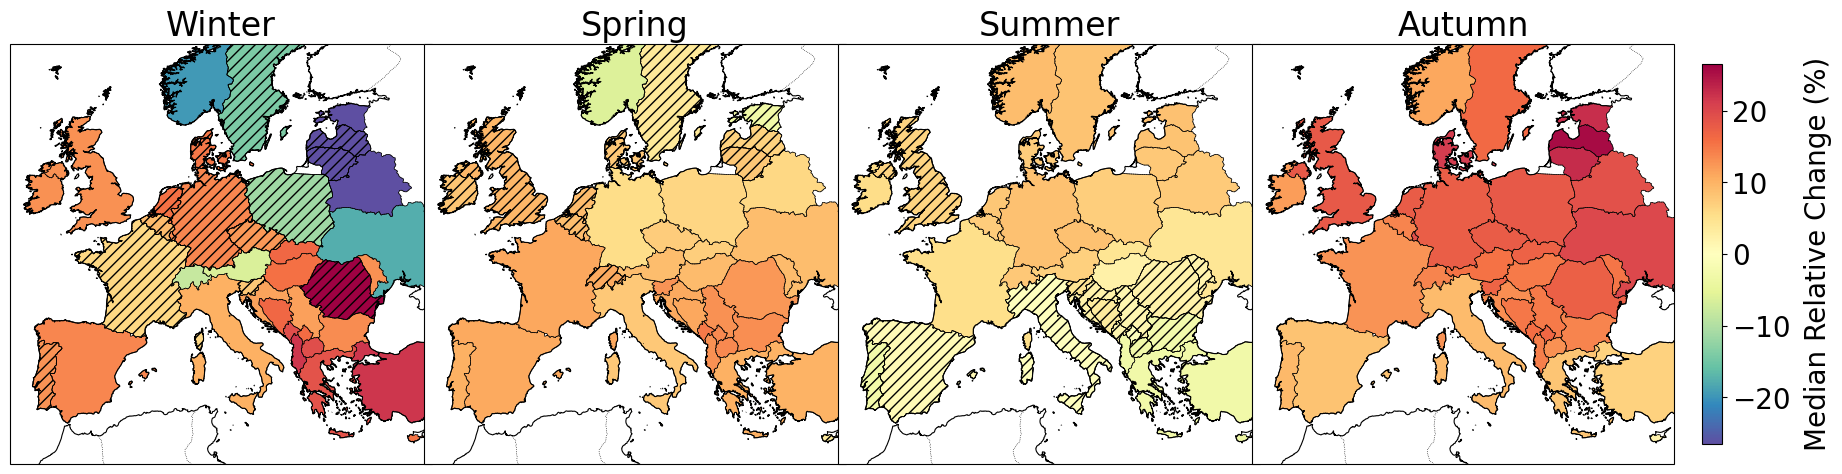

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm

# … load summary and eu_base exactly as before …

# Colormap
vmin = summary['median_rel_change_sig'].min()
vmax = summary['median_rel_change_sig'].max()
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
cmap = plt.get_cmap('Spectral_r')

seasons = ['Winter','Spring','Summer','Autumn']
proj = ccrs.PlateCarree()

# 1) Create 1×4 subplots, no constrained_layout
fig, axes = plt.subplots(
    1, 4,
    figsize=(20, 5),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

# 2) Plot each season
for ax, season in zip(axes, seasons):
    df = summary[summary['season']==season]
    eu = eu_base.merge(df[['ISO_A2','median_rel_change_sig']],
                       on='ISO_A2', how='left').fillna(0)
    sig = eu_base.merge(df[['ISO_A2','n_models_significant']],
                        on='ISO_A2', how='left').fillna(0)
    sig['n_models_significant'] = sig['n_models_significant'].astype(int)

    eu.plot(column='median_rel_change_sig',
            cmap=cmap, norm=norm,
            linewidth=0.5, edgecolor='black',
            ax=ax, missing_kwds={'color':'lightgrey'})

    low = sig[sig['n_models_significant']<5]
    low.plot(ax=ax, facecolor='none',
             edgecolor='black', hatch='///',
             linewidth=0.5, zorder=3)

    ax.coastlines('10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12,35,33,64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])

    # enforce the lat‐correct aspect inside the fixed box
    lat0 = (33+64)/2
    ax.set_aspect(1/np.cos(np.deg2rad(lat0)), adjustable='box')

# 3) Remove any gutter between axes
fig.subplots_adjust(
    left=0.02, right=0.90,
    top=0.92, bottom=0.08,
    wspace=-0.2, hspace=0
)

# 4) Thin colorbar outside
cax = fig.add_axes([0.89, 0.12, 0.01, 0.76])  # x, y, width, height
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Median Relative Change (%)', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)

plt.savefig('/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_magnitude_power_1x4.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pycountry

# ─── 1) Load and preprocess your CSV ─────────────────────────────────
csv_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_seasonal_drought_tests.csv"
df = pd.read_csv(csv_path)

def iso3_to_iso2(iso3):
    if iso3=='KOS': return 'XK'
    if iso3=='MKD': return 'MK'
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 2) Count significant models per country×season ────────────────
summary = (
    df[df['significant']]
      .groupby(['ISO_A2','season'])['model']
      .nunique()
      .reset_index(name='n_models_significant')
)

seasons = ['Winter','Spring','Summer','Autumn']
codes = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
         'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
         'SK','SI','ES','SE','CY','GB','NO','BA','ME','RS','AL',
         'MK','CH','IS','TR','UA','BY','MD','XK']

# ensure zeros everywhere
full = pd.MultiIndex.from_product([codes, seasons], names=['ISO_A2','season'])
summary = summary.set_index(['ISO_A2','season']).reindex(full, fill_value=0).reset_index()

# ─── 3) Load geometries ────────────────────────────────────────────
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'
eu_base = world[world.ISO_A2.isin(codes)][['ISO_A2','geometry']].copy()

# ─── 4) Colormap/norm ──────────────────────────────────────────────
maxm = summary['n_models_significant'].max()
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)


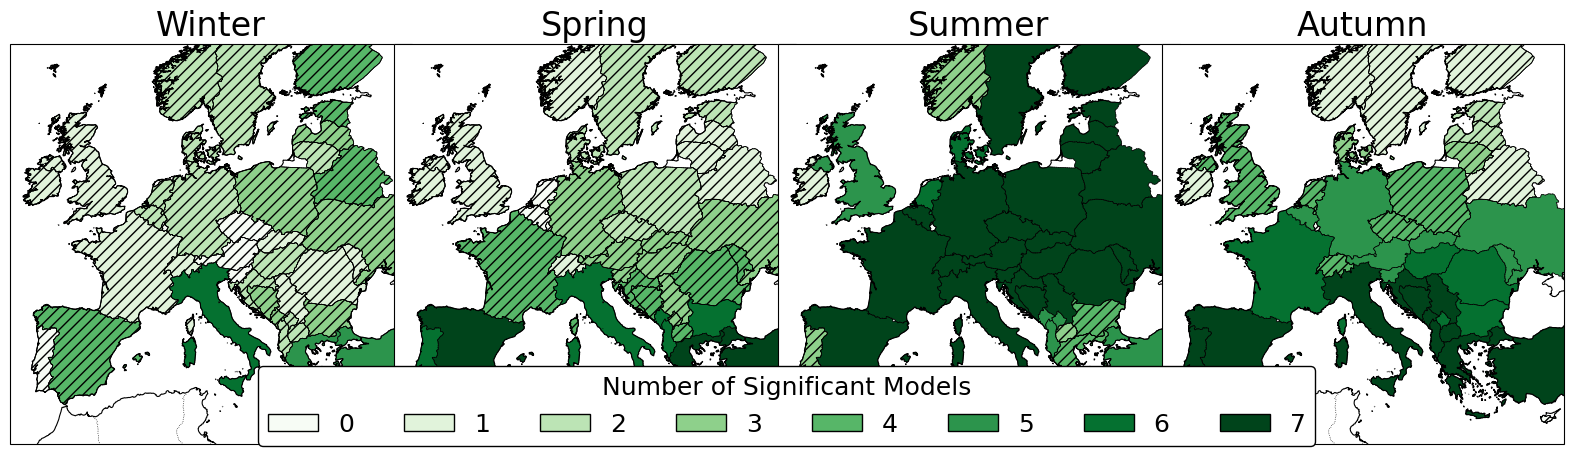

In [15]:
# ─── 5) Build 1×4 row ──────────────────────────────────────────────
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    1, 4, figsize=(20, 5),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

for ax, season in zip(axes, seasons):
    df_seas = summary[summary['season']==season][['ISO_A2','n_models_significant']]
    gdf = eu_base.merge(df_seas, on='ISO_A2', how='left')
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)

    # choropleth
    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, missing_kwds={'color':'lightgrey'}
    )
    # hatch low‐agreement
    low = gdf[gdf['n_models_significant']<5]
    low.plot(
        ax=ax, facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5, zorder=3
    )

    ax.coastlines('10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12,35,33,64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])

    # correct aspect in box
    lat0 = (33+64)/2
    ax.set_aspect(1/np.cos(np.deg2rad(lat0)), adjustable='box')

# 6) Reserve bottom space for the legend
fig.subplots_adjust(
    left=0.02, right=0.98,
    top=0.92, bottom=0.12,
    wspace=-0.5, hspace=0
)

# 7) Build legend patches (one for each integer from 0 to maxm)
patches = [
    mpatches.Patch(
        facecolor=cmap(i),
        edgecolor='black',
        label=str(i)
    )
    for i in range(maxm+1)
]

# 8) Draw a single horizontal legend under all four panels
fig.legend(
    handles=patches,
    title="Number of Significant Models",
    loc='lower center',
    ncol=8,
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.09),  # centered below panels
    framealpha=1
)

# 9) Save & show
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/agreement_seasonal_drought_days_1x4.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [16]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pycountry

# ─── 1) Load your raw seasonal t-test CSV ─────────────────────────────
csv_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/" \
           "power/country_seasonal_drought_tests.csv"
df = pd.read_csv(csv_path)
# expected columns: model, country (ISO3), season, mean_boc, mean_eoc, significant

# ─── 2) Map ISO-3 → ISO-2 (incl. KOS→XK, MKD→MK) ──────────────────────
def iso3_to_iso2(iso3):
    if iso3 == 'KOS': return 'XK'
    if iso3 == 'MKD': return 'MK'
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 3) Compute per‐country×season metrics ────────────────────────────
# filter only those models flagged significant
sig = df[df['significant']]

# count significant models
counts = (
    sig.groupby(['ISO_A2','season'])['model']
       .nunique()
       .rename('n_models_significant')
)

# median drought‐day difference among significant models
diffs = (
    sig.assign(diff = sig['mean_eoc'] - sig['mean_boc'])
       .groupby(['ISO_A2','season'])['diff']
       .median()
       .rename('median_drought_diff')
)

# combine into one DataFrame, then reindex full grid of country×season
seasons = ['Winter','Spring','Summer','Autumn']
# your full ISO_A2 list
EU27   = ['AT','BE','BG','HR','CZ','DK','EE','FR','DE','GR',
          'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
          'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','XK']
all_codes = EU27 + extras

idx = pd.MultiIndex.from_product([all_codes, seasons],
                                 names=['ISO_A2','season'])
summary = pd.concat([counts, diffs], axis=1).reindex(idx).fillna(0).reset_index()

# ─── 4) Load Natural Earth & force‐map ISO_A2 ─────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# force‐map a few
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'

eu_base = world[world.ISO_A2.isin(all_codes)][['ISO_A2','geometry']].copy()

# ─── 5) Prepare colormap (5–95% clip) ────────────────────────────────
vmin = summary['median_drought_diff'].quantile(0)
vmax = summary['median_drought_diff'].quantile(1)
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

base = plt.get_cmap('RdBu_r', 256)
colors = base(np.linspace(0,1,256))
# blend the top half (warm end) 50% with white
for i in range(128,256):
    colors[i] = 0.5*colors[i] + 0.5*np.array([1,1,1,1])
#light_cmap = LinearSegmentedColormap.from_list("LightRdBu", colors)
cmap="viridis_r"  # or use 'RdBu_r' for a more standard colormap



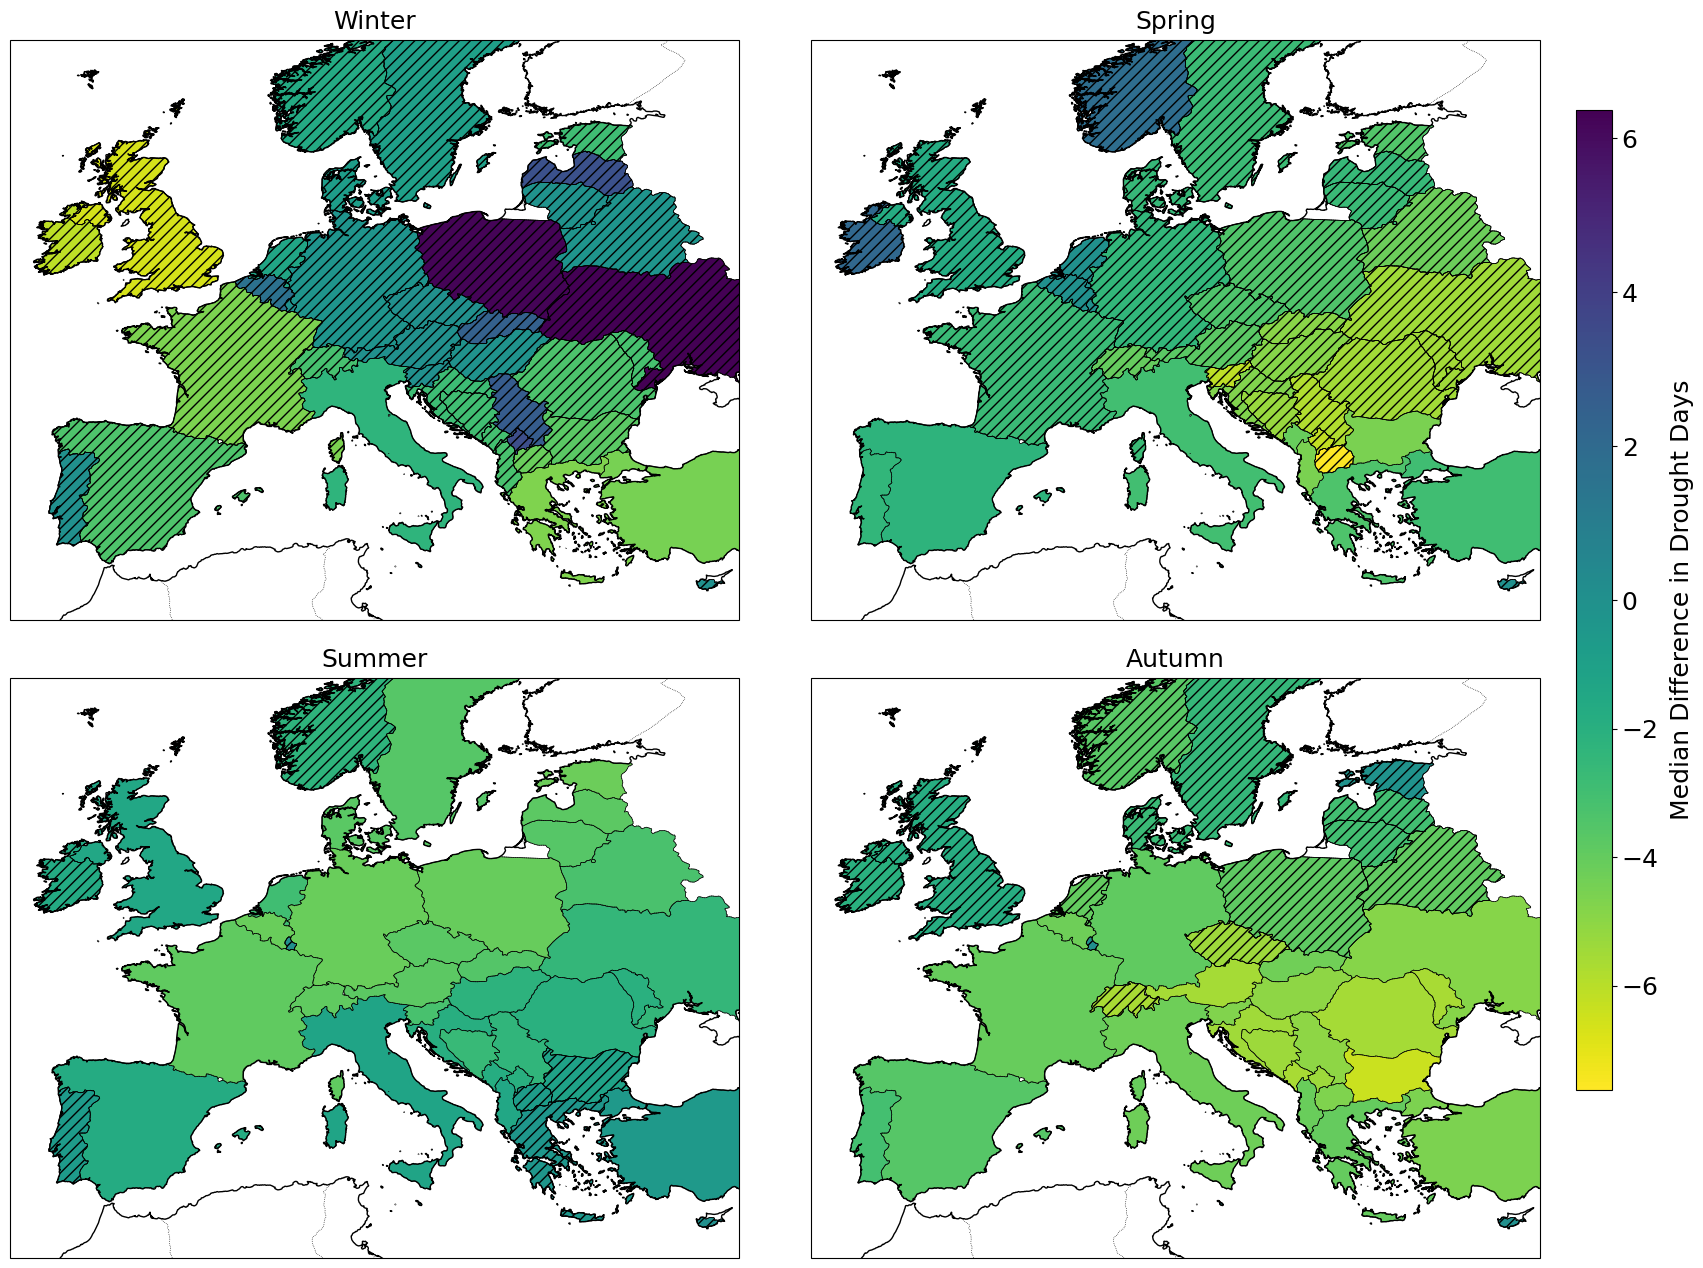

In [17]:
# ─── 6) Plot 2×2 seasonal panel ──────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(18,14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season']==season]
    gdf = eu_base.merge(
        df_seas[['ISO_A2','n_models_significant','median_drought_diff']],
        on='ISO_A2', how='left'
    )
    gdf['n_models_significant']   = gdf['n_models_significant'].fillna(0).astype(int)
    gdf['median_drought_diff']    = gdf['median_drought_diff'].fillna(0.0)

    # fill by diff
    gdf.plot(
        column='median_drought_diff',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, legend=False,
        missing_kwds={'color':'lightgrey'}
    )
    # hatch <5 agreeing models
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12,35,33,64], crs=ccrs.PlateCarree())
    ax.set_title(season, fontsize=18, pad=8)
    ax.set_aspect('auto')

fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.03,
    wspace=0.1, hspace=0.1
)


# shared colorbar
cax = fig.add_axes([0.90,0.15,0.02,0.7])
sm  = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A=[]
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Median Difference in Drought Days', fontsize=18, labelpad=8)
cbar.ax.tick_params(labelsize=18)
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/drought_days_seasonal_change.pdf", bbox_inches='tight', dpi=300)
plt.show()


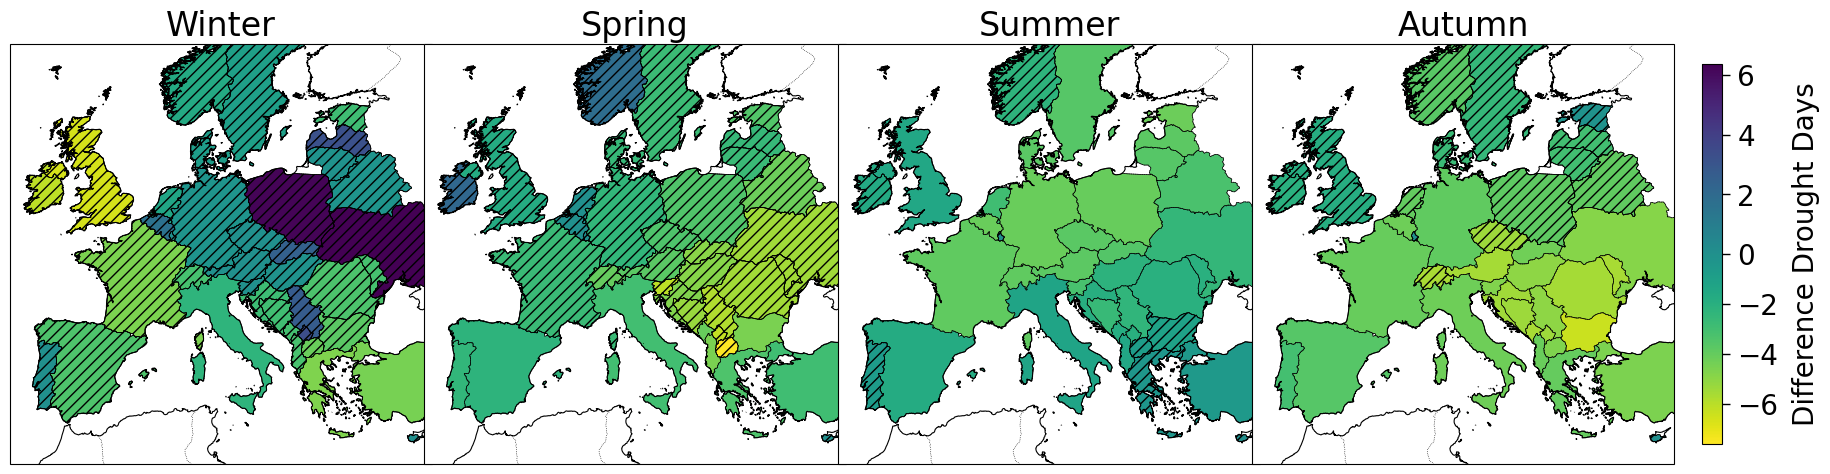

In [22]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pycountry

# ─── (1) Load & prep your summary DataFrame & eu_base exactly as before ───
# … [same loading, ISO-mapping, grouping, world & eu_base creation, vmin/vmax, norm, cmap] …

# for brevity, assume you already have:
#   summary: DataFrame with columns ['ISO_A2','season','n_models_significant','median_drought_diff']
#   eu_base: GeoDataFrame of all_codes geometries with column 'ISO_A2'
#   seasons = ['Winter','Spring','Summer','Autumn']
#   proj = ccrs.PlateCarree()
#   norm, cmap defined as before

# ─── (2) Create 1×4 subplots ────────────────────────────────────────────
fig, axes = plt.subplots(
    1, 4,
    figsize=(20, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes, seasons):
    df_seas = summary[summary['season']==season]
    # merge the two metrics back onto geometry
    gdf = eu_base.merge(
        df_seas[['ISO_A2','n_models_significant','median_drought_diff']],
        on='ISO_A2', how='left'
    ).fillna({'n_models_significant':0,'median_drought_diff':0.0})
    gdf['n_models_significant'] = gdf['n_models_significant'].astype(int)
    
    # plot the choropleth of median_drought_diff
    gdf.plot(
        column='median_drought_diff',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, missing_kwds={'color':'lightgrey'}
    )
    
    # hatch countries with <5 models
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )
    
    # map decorations
    ax.coastlines('10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])
    
    # enforce the lat-correct aspect inside the fixed box
    lat0 = (33+64)/2
    ax.set_aspect(1/np.cos(np.deg2rad(lat0)), adjustable='box')

# ─── (3) Tighten up spacing ───────────────────────────────────────────
fig.subplots_adjust(
    left=0.02, right=0.90,
    top=0.92, bottom=0.08,
    wspace=-0.2, hspace=0
)

# ─── (4) Add a single, slim, vertical colorbar on the right ────────────
cax = fig.add_axes([0.89, 0.12, 0.01, 0.76])  # [left, bottom, width, height]
sm  = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []  # dummy
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(
    'Difference Drought Days',
    fontsize=20, labelpad=10
)
cbar.ax.yaxis.set_tick_params(direction='in', length=6, width=1, labelsize=18)
cbar.locator = mpl.ticker.MaxNLocator(nbins=7, integer=True, )
cbar.update_ticks()
cbar.ax.tick_params(
    axis='y',        # we’re styling the y‐axis ticks
    which='both',    # apply to major and minor ticks
    direction='out', # tick‐marks point outward
    length=6,        # length of each tick
    width=1,         # thickness of tick lines
    pad=5,           # distance between tick and tick label
    labelsize=20     # font‐size of tick labels
)

# ─── (5) Save & show ───────────────────────────────────────────────────
plt.savefig(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/"
    "figures/drought_days_seasonal_1x4.pdf",
    bbox_inches='tight', dpi=300
)
plt.show()


In [2]:
import pandas as pd
import numpy as np
from country_converter import CountryConverter

# 1. Load seasonal CSVs
csv_power_seasonal = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/solar_model_stats_per_season.csv"
)
csv_drought_days_seasonal = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_seasonal_era5_vs_boc_days.csv"
)

# 2. Country list
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = ['GB', 'NO', 'BA', 'ME', 'RS', 'AL', 'MK', 'CH', 'IS', 'TR', 'UA', 'BY', 'MD', 'RU', 'XK']
countries_of_interest = EU27 + extras

# 3. Convert drought data from ISO_A3 to ISO_A2
cc = CountryConverter()
csv_drought_days_seasonal["ISO_A2"] = cc.convert(
    names=csv_drought_days_seasonal["country_ISO3"],
    to="ISO2",
    not_found=np.nan
)

# Handle Kosovo manually if needed
csv_drought_days_seasonal.loc[csv_drought_days_seasonal["country_ISO3"] == "KOS", "ISO_A2"] = "XK"

# 4. Filter significant results
power_sig = csv_power_seasonal[csv_power_seasonal["signif_ttest"] == True]
drought_sig = csv_drought_days_seasonal[csv_drought_days_seasonal["significant"] == True]

# 5. Filter countries of interest
power_sig = power_sig[power_sig["ISO_A2"].isin(countries_of_interest)]
drought_sig = drought_sig[drought_sig["ISO_A2"].isin(countries_of_interest)]

# 6. Match by country, season, and model
results = []

for country in countries_of_interest:
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        power_models = set(
            power_sig[
                (power_sig["ISO_A2"] == country) &
                (power_sig["season"] == season)
            ]["model"]
        )
        drought_models = set(
            drought_sig[
                (drought_sig["ISO_A2"] == country) &
                (drought_sig["season"] == season)
            ]["model"]
        )
        models_both = power_models & drought_models

        results.append({
            "country": country,
            "season": season,
            "models_power": len(power_models),
            "models_drought": len(drought_models),
            "models_both": len(models_both)
        })

# 7. Save or view the results
df_seasonal_agreement = pd.DataFrame(results)
print(df_seasonal_agreement)
# df_seasonal_agreement.to_csv("seasonal_model_agreement.csv", index=False)

KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3
KOS not found in ISO3


    country  season  models_power  models_drought  models_both
0        AT  Winter             7               7            7
1        AT  Spring             6               7            6
2        AT  Summer             7               5            5
3        AT  Autumn             7               5            5
4        BE  Winter             4               7            4
..      ...     ...           ...             ...          ...
163      RU  Autumn             6               4            3
164      XK  Winter             7               7            7
165      XK  Spring             6               7            6
166      XK  Summer             4               4            4
167      XK  Autumn             7               5            5

[168 rows x 5 columns]


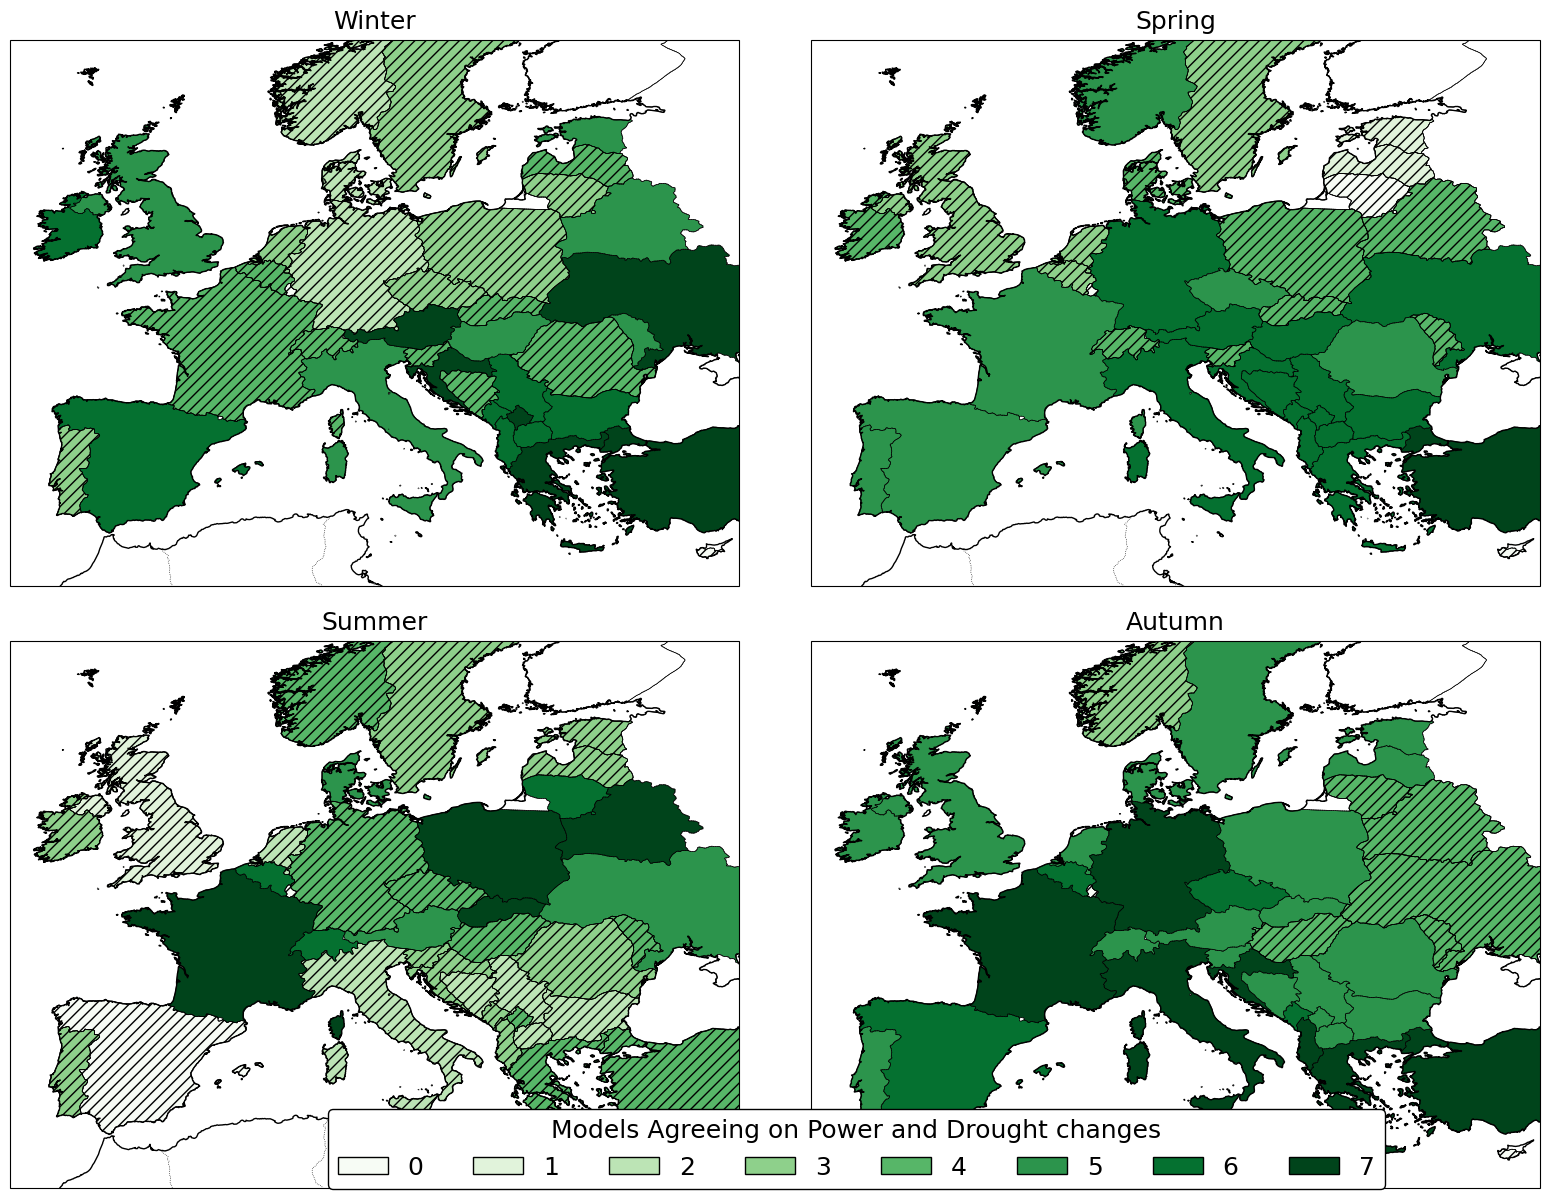

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 1. Load seasonal agreement data
summary = df_seasonal_agreement.copy()

# 2. Regions
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
    'UA','BY','MD','RU','XK'
]
region_codes = EU27 + extras

# 3. Country geometries
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',  'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway',  'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# 4. Optional: rename season codes to readable titles
season_map = {
    'Winter': 'Winter',
    'Spring': 'Spring',
    'Summer': 'Summer',
    'Autumn': 'Autumn'
}
summary['season_title'] = summary['season'].map(season_map)

# 5. Prepare colormap
maxm = int(summary['models_both'].max())
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# 6. Seasons and panel setup
seasons = ['Winter','Spring','Summer','Autumn']
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

# 7. Plot per season
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season_title'] == season]
    gdf = eu.merge(
        df_seas[['country','models_both']].rename(columns={'country':'ISO_A2'}),
        on='ISO_A2',
        how='left'
    )

    # Fill missing with 0 and convert to int
    gdf['models_both'] = gdf['models_both'].fillna(0).astype(int)
    gdf.loc[gdf['ISO_A2'].isin(['RU','FI']), 'models_both'] = np.nan

    # Main plot
    gdf.plot(
        column='models_both',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'white'}
    )

    # Hatch countries with low agreement (< 5 models)
    low = gdf[gdf['models_both'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        hatch='///',
        linewidth=0.5,
        zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')
    ax.set_title(season, fontsize=18, pad=8)

# 8. Shared legend and layout
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)

patches = [
    mpatches.Patch(
        facecolor=cmap(i),
        edgecolor='black',
        linewidth=1.0,
        label=f"{i}"
    ) for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Models Agreeing on Power and Drought changes",
    loc='lower center',
    ncol=8,
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.07),
    framealpha=1
)

# 9. Save and show
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_agreement_power_and_drought.pdf", bbox_inches='tight', dpi=300)
plt.show()


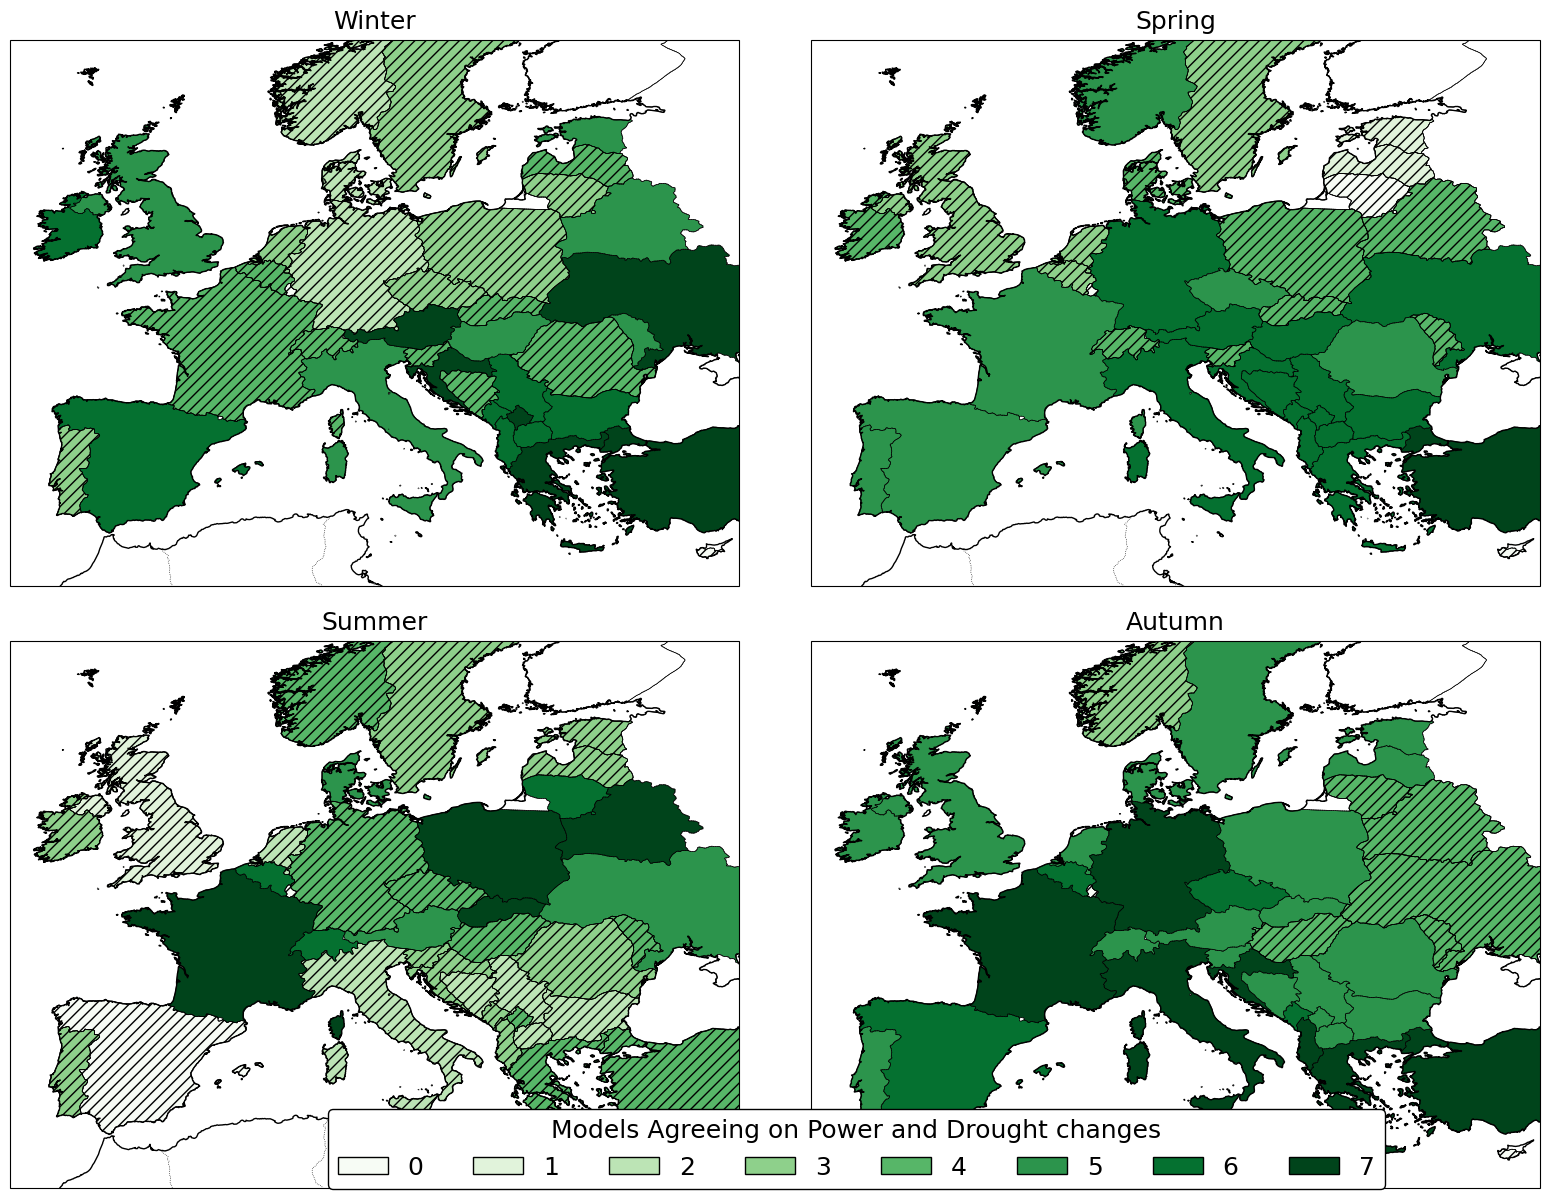

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 1. Load seasonal agreement data
summary = df_seasonal_agreement.copy()

# 2. Regions
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
    'UA','BY','MD','RU','XK'
]
region_codes = EU27 + extras

# 3. Country geometries
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',  'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway',  'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# 4. Optional: rename season codes to readable titles
season_map = {
    'Winter': 'Winter',
    'Spring': 'Spring',
    'Summer': 'Summer',
    'Autumn': 'Autumn'
}
summary['season_title'] = summary['season'].map(season_map)

# 5. Prepare colormap
maxm = int(summary['models_both'].max())
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# 6. Seasons and panel setup
seasons = ['Winter','Spring','Summer','Autumn']
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

# 7. Plot per season
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season_title'] == season]
    gdf = eu.merge(
        df_seas[['country','models_both']].rename(columns={'country':'ISO_A2'}),
        on='ISO_A2',
        how='left'
    )

    # Fill missing with 0 and convert to int
    gdf['models_both'] = gdf['models_both'].fillna(0).astype(int)
    gdf.loc[gdf['ISO_A2'].isin(['RU','FI']), 'models_both'] = np.nan

    # Main plot
    gdf.plot(
        column='models_both',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'white'}
    )

    # Hatch countries with low agreement (< 5 models)
    low = gdf[gdf['models_both'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        hatch='///',
        linewidth=0.5,
        zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')
    ax.set_title(season, fontsize=18, pad=8)

# 8. Shared legend and layout
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)

patches = [
    mpatches.Patch(
        facecolor=cmap(i),
        edgecolor='black',
        linewidth=1.0,
        label=f"{i}"
    ) for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Models Agreeing on Power and Drought changes",
    loc='lower center',
    ncol=8,
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.07),
    framealpha=1
)

# 9. Save and show
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_agreement_power_and_drought.pdf", bbox_inches='tight', dpi=300)
plt.show()

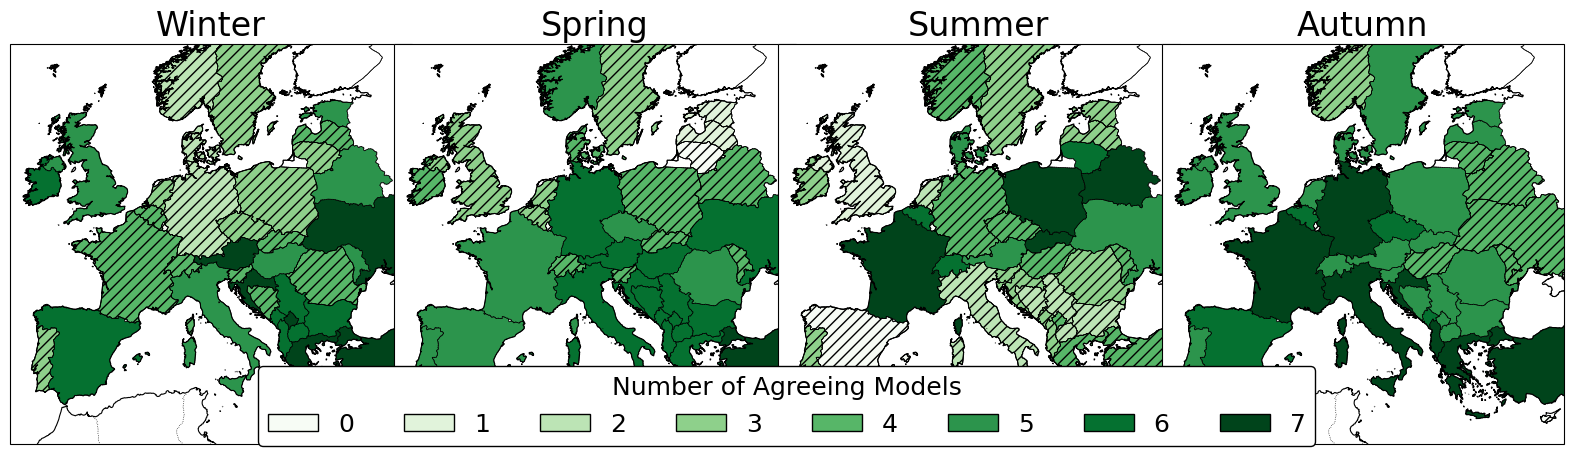

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import numpy as np

# (1) Data and region prep
summary = df_seasonal_agreement.copy()

EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','RU','XK']
region_codes = EU27 + extras

ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG == 'France', 'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG == 'Norway', 'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2', 'geometry']].copy()

# (2) Colormap setup
maxm = int(summary['models_both'].max())
cmap = plt.get_cmap('Greens', maxm + 1)
norm = BoundaryNorm(np.arange(maxm + 2) - 0.5, maxm + 1)

# (3) Seasons and panel setup
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
proj = ccrs.PlateCarree()

fig, axes = plt.subplots(
    1, 4, figsize=(20, 5),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

for ax, season in zip(axes, seasons):
    df_seas = summary[summary['season'] == season]
    gdf = eu.merge(
        df_seas[['country', 'models_both']].rename(columns={'country': 'ISO_A2'}),
        on='ISO_A2', how='left'
    ).fillna({'models_both': 0})
    gdf['models_both'] = gdf['models_both'].astype(int)
    gdf.loc[gdf['ISO_A2'].isin(['RU', 'FI']), 'models_both'] = np.nan

    # Plot main map
    gdf.plot(
        column='models_both',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, missing_kwds={'color': 'white'}
    )

    # Hatch low-agreement countries
    low = gdf[gdf['models_both'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )

    # Map decorations
    ax.coastlines('10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])

    # Preserve correct aspect ratio
    lat0 = (33 + 64) / 2
    ax.set_aspect(1 / np.cos(np.deg2rad(lat0)), adjustable='box')

# (6) Reserve bottom space for the legend
fig.subplots_adjust(
    left=0.02, right=0.98,
    top=0.92, bottom=0.12,
    wspace=-0.5, hspace=0
)

# (7) Build legend patches (discrete values from 0 to maxm)
patches = [
    mpatches.Patch(
        facecolor=cmap(i),
        edgecolor='black',
        label=str(i)
    )
    for i in range(maxm + 1)
]

# (8) Draw a horizontal legend centered below the subplots
fig.legend(
    handles=patches,
    title="Number of Agreeing Models",
    loc='lower center',
    ncol=min(10, maxm + 1),
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.09),
    framealpha=1
)


# (5) Save & Show

plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/seasonal_agreement_power_and_drought_1x4.pdf", bbox_inches='tight', dpi=300)
plt.show()



In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl
import pycountry

# ─── 1) Load your ERA5 vs BOC seasonal stats ─────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
stats_csv = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df = pd.read_csv(stats_csv)
# expects columns: model, country_ISO3, season, ..., significant

# ─── 2) Map ISO3→ISO2 for plotting with NaturalEarth geometries ─────
def iso3_to_iso2(iso3):
    if iso3 == "KOS": return "XK"
    if iso3 == "MKD": return "MK"
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df["ISO_A2"] = df["country_ISO3"].map(iso3_to_iso2)
df = df.dropna(subset=["ISO_A2"])

# ─── 2) Count per country_ISO3×season how many models are significant ─
seasons = ["Winter","Spring","Summer","Autumn"]
counts = (
    df[df["significant"]]
      .groupby(["country_ISO3","season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

# ensure every combination appears
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full = pd.MultiIndex.from_product([all_iso3, seasons], names=["country_ISO3","season"])
counts = (
    counts
      .set_index(["country_ISO3","season"])
      .reindex(full, fill_value=0)
      .reset_index()
)

# ─── 3) Load Natural Earth by ISO3 ──────────────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")

# force-correct Kosovo and Türki‌ye
world.loc[world.ADM0_A3=="RKS",      "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG=="Türkiye","ADM0_A3"] = "TUR"

# subset to our list
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"country_ISO3"})

# ─── 4) Merge geometries + counts ───────────────────────────────────
gdf = eu.merge(counts, on="country_ISO3", how="left")
gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)

# ─── 5) Prepare colormap ────────────────────────────────────────────
max_models = df["model"].nunique()
cmap = plt.get_cmap("Greens", max_models+1)
norm = mpl.colors.BoundaryNorm(np.arange(max_models+2)-0.5, max_models+1)


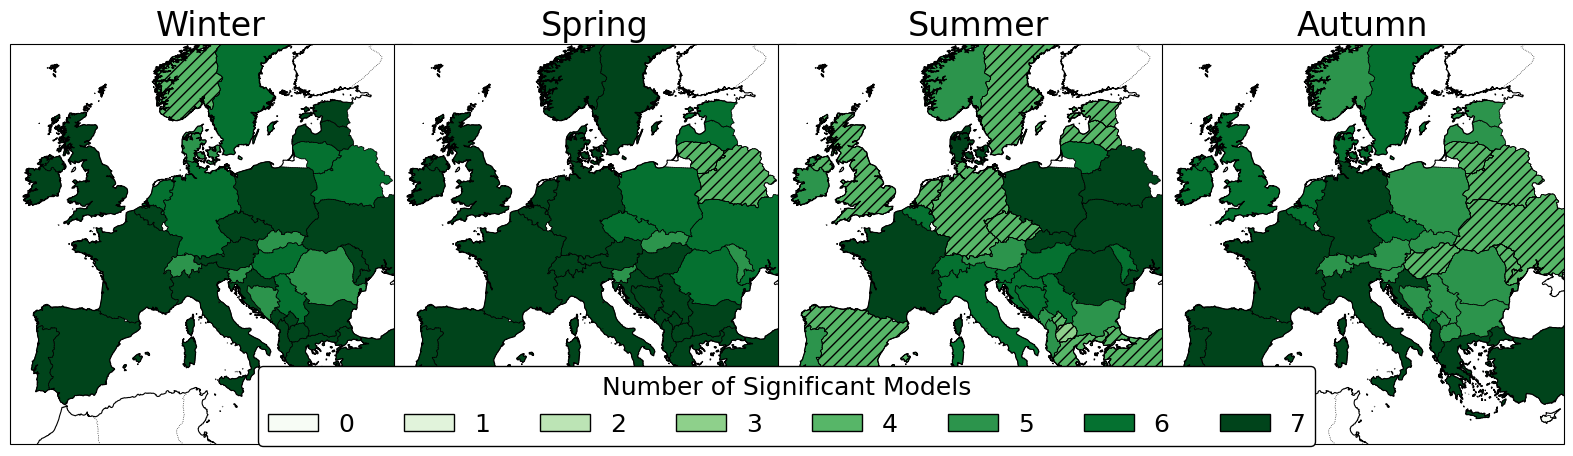

1x4 seasonal drought days difference model agreement plot saved.


In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl
import pycountry

# ─── 1) Load ERA5 vs BOC seasonal stats ─────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
stats_csv = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df = pd.read_csv(stats_csv)

# ─── 2) ISO3→ISO2 for consistency ──────────────────────────────────
def iso3_to_iso2(iso3):
    if iso3 == "KOS": return "XK"
    if iso3 == "MKD": return "MK"
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df["ISO_A2"] = df["country_ISO3"].map(iso3_to_iso2)
df = df.dropna(subset=["ISO_A2"])

# ─── 3) Count how many models are significant ──────────────────────
seasons = ["Winter","Spring","Summer","Autumn"]
counts = (
    df[df["significant"]]
      .groupby(["country_ISO3","season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full_index = pd.MultiIndex.from_product([all_iso3, seasons], names=["country_ISO3","season"])
counts = (
    counts.set_index(["country_ISO3", "season"])
          .reindex(full_index, fill_value=0)
          .reset_index()
)

# ─── 4) Load Natural Earth and match ISO3 ───────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"] = "TUR"

geoms = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3", "geometry"]].rename(columns={"ADM0_A3": "country_ISO3"})

# ─── 5) Merge with geometries ───────────────────────────────────────
gdf = geoms.merge(counts, on="country_ISO3", how="left")
gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)

# ─── 6) Colormap setup ──────────────────────────────────────────────
max_models = df["model"].nunique()
cmap = plt.get_cmap("Greens", max_models + 1)
norm = mpl.colors.BoundaryNorm(np.arange(max_models + 2) - 0.5, max_models + 1)

# ─── 7) 1×4 Panel Plot ───────────────────────────────────────────────
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={"projection": proj})

for ax, season in zip(axes, seasons):
    sub = gdf[gdf["season"] == season]

    sub.plot(
        column="n_models_significant",
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor="black",
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    low = sub[(sub["n_models_significant"] > 0) & (sub["n_models_significant"] < 5)]
    if not low.empty:
        low.plot(
            facecolor="none", edgecolor="black",
            hatch="///", linewidth=0.5,
            ax=ax, zorder=3
        )

    ax.coastlines("10m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])
    lat0 = (33 + 64) / 2
    ax.set_aspect(1 / np.cos(np.deg2rad(lat0)), adjustable="box")

# ─── 8) Adjust Layout and Legend ────────────────────────────────────
fig.subplots_adjust(
    left=0.02, right=0.98,
    top=0.92, bottom=0.12,
    wspace=-0.5, hspace=0
)

patches = [
    mpatches.Patch(facecolor=cmap(i), edgecolor="black", label=str(i))
    for i in range(max_models + 1)
]

fig.legend(
    handles=patches,
    title="Number of Significant Models",
    loc="lower center",
    ncol=min(10, max_models + 1),
    fontsize=18,
    title_fontsize=18,
    frameon=True,
    edgecolor="black",
    bbox_to_anchor=(0.5, 0.09),
    framealpha=1
)

# ─── 9) Save and Show ───────────────────────────────────────────────
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/ERA5_seasonal_agreement_drought_days_1x4.pdf", bbox_inches='tight', dpi=300)
plt.show()
print("1x4 seasonal drought days difference model agreement plot saved.")


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# ─── 1) Read in the seasonal stats CSV ──────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path  = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df        = pd.read_csv(csv_path)
# expects columns: model, country_ISO3, season, mean_era5_days, mean_boc_days, diff_days, significant

# ─── 2) For each country_ISO3×season:
#     a) median of diff_days
#     b) count of significant models
seasons = ["Winter","Spring","Summer","Autumn"]
med_diff = (
    df.groupby(["country_ISO3","season"])["diff_days"]
      .median()
      .reset_index(name="median_diff")
)
counts   = (
    df[df["significant"]]
      .groupby(["country_ISO3","season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

# fill missing combos
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full = pd.MultiIndex.from_product([all_iso3, seasons],
                                  names=["country_ISO3","season"])
med  = med_diff.set_index(["country_ISO3","season"]).reindex(full).reset_index()
cnt  = counts.set_index(["country_ISO3","season"]).reindex(full, fill_value=0).reset_index()
summary = med.merge(cnt, on=["country_ISO3","season"])

# ─── 3) Load country geometries keyed by ISO3 ───────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# fix Kosovo & Türkiye
world.loc[world.ADM0_A3 == "RKS",       "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"] = "TUR"

eu = (
    world[world.ADM0_A3.isin(all_iso3)]
      [["ADM0_A3","geometry"]]
      .rename(columns={"ADM0_A3":"country_ISO3"})
)

gdf = eu.merge(summary, on="country_ISO3", how="left")

# Countries with zero agreement → mask their median_diff to NaN so they plot grey
gdf.loc[gdf["n_models_significant"] == 0, "median_diff"] = np.nan

# ─── 4) Set up diverging colormap clipped at 5–95% ──────────────────
vmin = gdf["median_diff"].min()
vmax = gdf["median_diff"].max()
cmap = plt.get_cmap("plasma_r")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

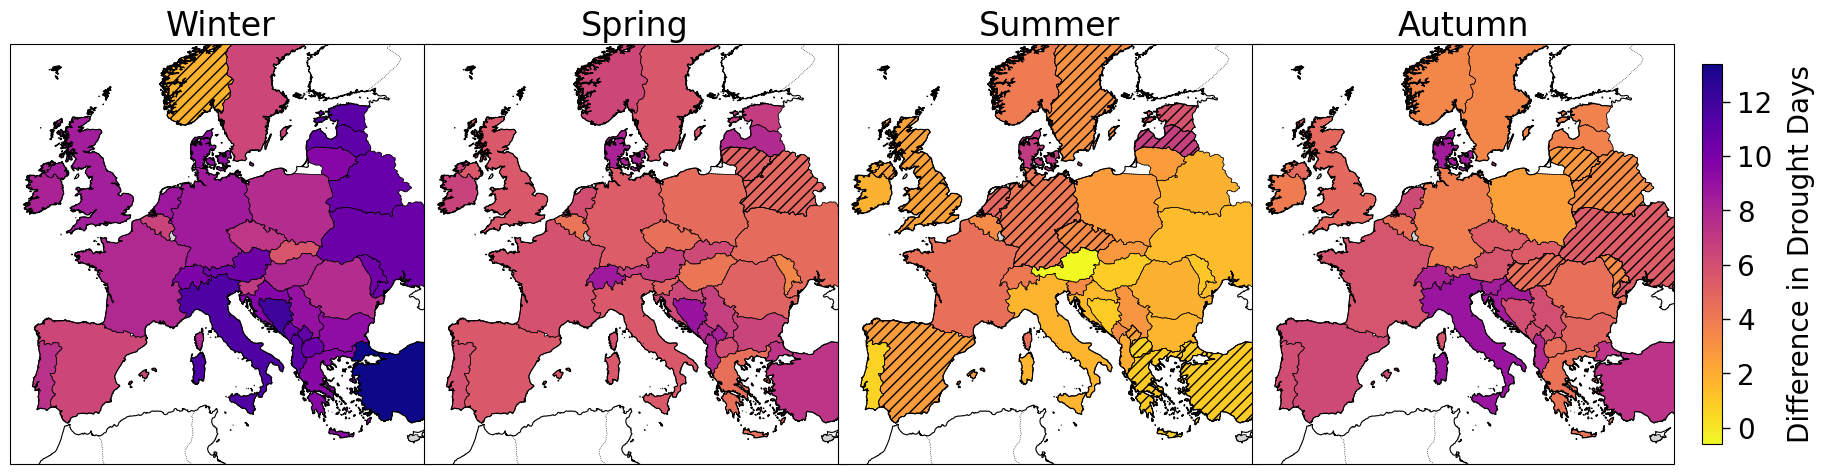

In [6]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# ─── 1) Load seasonal stats CSV ──────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path = os.path.join(power_dir, "country_seasonal_era5_vs_boc_days.csv")
df = pd.read_csv(csv_path)

# ─── 2) Median differences and significant counts per country×season ─
seasons = ["Winter", "Spring", "Summer", "Autumn"]
med_diff = (
    df.groupby(["country_ISO3", "season"])["diff_days"]
      .median()
      .reset_index(name="median_diff")
)
counts = (
    df[df["significant"]]
      .groupby(["country_ISO3", "season"])["model"]
      .nunique()
      .reset_index(name="n_models_significant")
)

# ─── 3) Fill missing country×season with full list ───────────────────
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

full_idx = pd.MultiIndex.from_product([all_iso3, seasons], names=["country_ISO3", "season"])
med = med_diff.set_index(["country_ISO3", "season"]).reindex(full_idx).reset_index()
cnt = counts.set_index(["country_ISO3", "season"]).reindex(full_idx, fill_value=0).reset_index()
summary = med.merge(cnt, on=["country_ISO3", "season"])

# ─── 4) Load and fix world geometries ────────────────────────────────
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
world.loc[world.NAME_LONG == "Türkiye", "ADM0_A3"] = "TUR"

eu_base = (
    world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3", "geometry"]]
    .rename(columns={"ADM0_A3": "country_ISO3"})
)

# ─── 5) Prepare color normalization ──────────────────────────────────
vmin = summary["median_diff"].min()
vmax = summary["median_diff"].max()
cmap = plt.get_cmap("plasma_r")  # do not change
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ─── 6) Plot 1×4 seasonal panel ──────────────────────────────────────
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': proj})

for ax, season in zip(axes, seasons):
    df_seas = summary[summary["season"] == season]

    gdf = eu_base.merge(df_seas, on="country_ISO3", how="left")
    gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)
    gdf.loc[gdf["n_models_significant"] == 0, "median_diff"] = np.nan  # grey if no agreement

    gdf.plot(
        column="median_diff",
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor="black",
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    low = gdf[(gdf["n_models_significant"] > 0) & (gdf["n_models_significant"] < 5)]
    if not low.empty:
        low.plot(
            facecolor="none", edgecolor="black",
            hatch="///", linewidth=0.5,
            ax=ax, zorder=3
        )

    ax.coastlines("10m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=proj)
    ax.set_title(season, fontsize=24, pad=6)
    ax.set_xticks([]); ax.set_yticks([])
    lat0 = (33 + 64) / 2
    ax.set_aspect(1 / np.cos(np.deg2rad(lat0)), adjustable='box')

# ─── 7) Adjust spacing ───────────────────────────────────────────────
fig.subplots_adjust(
    left=0.02, right=0.90,
    top=0.92, bottom=0.08,
    wspace=-0.2, hspace=0
)

# ─── 8) Add vertical colorbar ────────────────────────────────────────
cax = fig.add_axes([0.89, 0.12, 0.01, 0.76])  # [left, bottom, width, height]
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label("Difference in Drought Days", fontsize=20, labelpad=10)
cbar.ax.tick_params(
    axis='y', which='both',
    direction='out', length=6,
    width=1, pad=5, labelsize=20
)
cbar.locator = mpl.ticker.MaxNLocator(nbins=7, integer=True)
cbar.update_ticks()

# ─── 9) Save & show ──────────────────────────────────────────────────
plt.savefig(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/era5_boc_drought_days_seasonal_1x4.pdf",
    bbox_inches='tight', dpi=300
)
plt.show()
